# Collection and Analysis of Consumption Data
Consumption data is critical to understanding, in greater detail, the flow of people (and therefore economic activity) through the world. 

I start with ride data from UBER which will allow me to see when throughout the day/week people are moving the most and where they most often travel between.

In [2]:
import pandas as pd
#Read in the dataset of july uber pickups
uber_data = pd.read_csv("files/uber-raw-data-jul14.csv")
print(uber_data.head(10))

          Date/Time      Lat      Lon    Base
0  7/1/2014 0:03:00  40.7586 -73.9706  B02512
1  7/1/2014 0:05:00  40.7605 -73.9994  B02512
2  7/1/2014 0:06:00  40.7320 -73.9999  B02512
3  7/1/2014 0:09:00  40.7635 -73.9793  B02512
4  7/1/2014 0:20:00  40.7204 -74.0047  B02512
5  7/1/2014 0:35:00  40.7487 -73.9869  B02512
6  7/1/2014 0:57:00  40.7444 -73.9961  B02512
7  7/1/2014 0:58:00  40.7132 -73.9492  B02512
8  7/1/2014 1:04:00  40.7590 -73.9730  B02512
9  7/1/2014 1:08:00  40.7601 -73.9823  B02512


In [3]:
#Convert the date/time data to EURO style. Note I can condense 
#the data into hour-long segments for easier analysis.
uber_data["Date/Time"] = pd.to_datetime(uber_data["Date/Time"])
print(uber_data["Date/Time"].dt.floor('1H').value_counts().head(10))

2014-07-15 18:00:00    3302
2014-07-15 19:00:00    3225
2014-07-15 17:00:00    3045
2014-07-02 18:00:00    2946
2014-07-15 20:00:00    2840
2014-07-23 20:00:00    2791
2014-07-23 21:00:00    2559
2014-07-31 18:00:00    2531
2014-07-23 17:00:00    2519
2014-07-02 17:00:00    2479
Name: Date/Time, dtype: int64


In [6]:
#Sort this hourly data by time.
hourly_data = uber_data["Date/Time"].dt.floor('1H').value_counts()
hourly_data = hourly_data.sort_index()
print(hourly_data.head(10))

2014-07-01 00:00:00     216
2014-07-01 01:00:00     111
2014-07-01 02:00:00      82
2014-07-01 03:00:00     134
2014-07-01 04:00:00     223
2014-07-01 05:00:00     348
2014-07-01 06:00:00     715
2014-07-01 07:00:00    1196
2014-07-01 08:00:00    1076
2014-07-01 09:00:00     885
Name: Date/Time, dtype: int64


### Seasonality Time Series

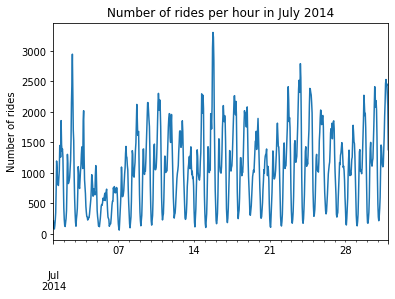

In [22]:
import matplotlib.pyplot as plt
hourly_data.plot(kind="line")
plt.ylabel('Number of rides')
plt.title('Number of rides per hour in July 2014')
plt.show()

Notice the periodic fluctuations in number of rides taken throughout the month. One can reasonably conclude that the peaks are around rush hour (mornings/evenings) and the minima occur during overnight hours.

### Changing Perspective

I want to see if there are any patterns in the average numbers of rides as they occur throughout the week. Do some weekdays have a higher occurance of rides? 

I create separate pointers for hours, weekdays, and actual dates and concatenate them together into a new dataset.

In [32]:
hours = uber_data["Date/Time"].dt.hour
week_day = uber_data["Date/Time"].dt.weekday
date = uber_data["Date/Time"].dt.date

weekly_data = pd.concat([week_day, hours, date], axis=1)
weekly_data.columns = ["Week Day", "Hour", "Date"]

print(weekly_data.head(5))

   Week Day  Hour        Date
0         1     0  2014-07-01
1         1     0  2014-07-01
2         1     0  2014-07-01
3         1     0  2014-07-01
4         1     0  2014-07-01


In [33]:
# To convert from week day number to the actual day name, 
# I can use the calendar library.
import calendar
weekly_data["Week Day"] = weekly_data["Week Day"].apply(lambda x: calendar.day_name[x])
print(weekly_data.head(5))

  Week Day  Hour        Date
0  Tuesday     0  2014-07-01
1  Tuesday     0  2014-07-01
2  Tuesday     0  2014-07-01
3  Tuesday     0  2014-07-01
4  Tuesday     0  2014-07-01


In [34]:
# I can group by date, week day, and hour and then aggregate by size
# (# of entries on each day per hour)
weekly_data = weekly_data.groupby(["Date","Week Day", "Hour"]).size()
print(weekly_data.head(5))

Date        Week Day  Hour
2014-07-01  Tuesday   0       216
                      1       111
                      2        82
                      3       134
                      4       223
dtype: int64


In [35]:
# Reset index to fill in week day and date data and rename size column
weekly_data = weekly_data.reset_index()
weekly_data = weekly_data.rename(columns={0: "Size"})
print(weekly_data.head(5))

         Date Week Day  Hour  Size
0  2014-07-01  Tuesday     0   216
1  2014-07-01  Tuesday     1   111
2  2014-07-01  Tuesday     2    82
3  2014-07-01  Tuesday     3   134
4  2014-07-01  Tuesday     4   223


In [36]:
#Now I group by the week day and average to get the mean for each week day/hour
weekly_data = weekly_data.groupby(["Week Day", "Hour"]).mean()["Size"]
print(weekly_data.head(5))

Week Day  Hour
Friday    0       615.00
          1       385.25
          2       264.75
          3       307.50
          4       339.75
Name: Size, dtype: float64


In [39]:
#Unstack takes a level of the index and translates it to be a column
#I pick level=0 because I want the week day name to be the column
weekly_data = weekly_data.unstack(level=0)

# I reindex to match a typical work week (week days then weekend)
weekly_data = weekly_data.reindex(columns=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
print(weekly_data)

Week Day   Monday  Tuesday  Wednesday  Thursday   Friday  Saturday   Sunday
Hour                                                                       
0          315.00    301.8      354.6     430.0   615.00   1110.25  1090.00
1          153.25    155.8      193.2     231.4   385.25    788.25   829.50
2          109.75    111.2      156.0     171.0   264.75    580.00   638.25
3          254.75    187.0      224.0     256.6   307.50    426.00   477.00
4          403.75    296.6      326.0     376.8   339.75    271.75   245.50
5          615.25    546.0      559.8     586.2   497.25    274.25   231.25
6          911.00    962.2     1003.4     959.2   736.75    303.50   256.75
7         1266.50   1350.0     1425.8    1341.8  1008.00    398.50   316.25
8         1199.25   1332.4     1425.0    1336.6  1038.00    525.25   466.75
9          923.00   1012.2     1083.8    1077.0   907.75    667.00   657.50
10         855.75    977.4     1035.2    1014.2   875.75    823.25   801.25
11         8

### Heatmap visualization
This collection of hour/day ride averages can be visualized as a heatmap for easy interpretation.

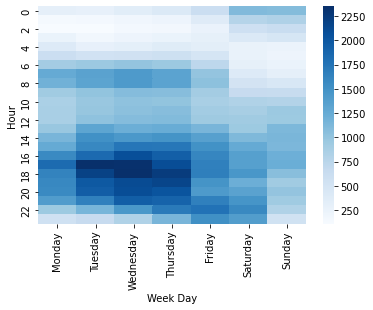

In [40]:
import seaborn as sns
sns.heatmap(weekly_data, cmap="Blues")
plt.show()

I can see clear behavioral trends that logically follow my common sense guesses for how people move around throughout the week. The biggest peak of movement is associated with the end of the work day with UBER use extending later into the night as the week wears on to Friday.

But, this data on its own doesn't really tell me much about "economic activity" and is not useful for me to make any monetary decisions off of. I can diversify this data and the perspective it lends by using geopositional data to see how far people are travelling and where they are going.

## Geopositional Data: Points of Interest
I am using the python library `geopy` to work with longtitude and latitude measurements.

To measure the distance traveled across the surface of a sphere, I am using my own custom Haversine formula. Geopy has a built in method for this but I find it to take a considerably long time for lots of data. Not sure why it's so poorly optimized. 

Each entry in the UBER data has a start and end latitude and longtitude. To start things off simply I want to show how many rides initiate near some NYC landmarks like the Met and ESB.

Building up from this, I should be able to represent these "locale" rides on a heatmap superimposed onto a map of Manhattan. Baby steps.

In [54]:
import geopy.distance
#Check to make sure latitude and longitude are in the right order
metro_art_coordinates = (40.7794, -73.9632)
empire_state_building_coordinates = (40.7484, -73.9857)

# Built-in geopy distance method, I'll use my own.
distance = geopy.distance.distance(metro_art_coordinates, empire_state_building_coordinates)
print(distance)
print(distance.mi)

3.9319431838516716 km
2.443196223959372


In [55]:
from math import radians, cos, sin, asin, sqrt

def haversine(coordinates1, coordinates2):

    lon1 = coordinates1[1]
    lat1 = coordinates1[0]
    lon2 = coordinates2[1]
    lat2 = coordinates2[0]
    #Change to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    
    
    # Apply the harversine formula
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 3956
    return c * r
print(haversine(metro_art_coordinates, empire_state_building_coordinates))

2.442501323483997


In [56]:
#Now, I can find the distances to both attractions
# I am passing the data through a lambda that converts the Lat Lon data to tuples before passing to haversine
uber_data["Distance MM"] = uber_data[["Lat", "Lon"]].apply(lambda x: haversine(metro_art_coordinates,tuple(x)),axis=1)
uber_data["Distance ESB"] = uber_data[["Lat", "Lon"]].apply(lambda x: haversine(empire_state_building_coordinates,tuple(x)),axis=1)
print(uber_data["Distance MM"].head(5))
print(uber_data["Distance ESB"].head(5))

0    1.487358
1    2.299140
2    3.794105
3    1.383450
4    4.615925
Name: Distance MM, dtype: float64
0    1.058178
1    1.100642
2    1.354266
3    1.094999
4    2.173858
Name: Distance ESB, dtype: float64


In [57]:
#Summarize the data
print(uber_data[["Distance MM", "Distance ESB"]].describe())

#Using boolean indexing, we can sum to find the count within a specified range
print("\nNumber of rides < 0.25mi")
print((uber_data[["Distance MM", "Distance ESB"]] < .25).sum())

         Distance MM   Distance ESB
count  796121.000000  796121.000000
mean        3.868244       2.723783
std         3.200848       3.276343
min         0.037592       0.000000
25%         1.863763       0.976621
50%         3.329218       1.726115
75%         4.691434       3.037256
max        86.770131      88.188585

Number of rides < 0.25mi
Distance MM      2764
Distance ESB    15133
dtype: int64


Great! So now that I have a framework that can be easily parsed. Next, I'll build out a radial profile to see a cummulative perspective of how rides are clustered around these landmarks.

In [58]:
import numpy as np
#Distance range takes a start, end (non-inclusive) and step amount
distance_range = np.arange(.1,5.1,.1)

distance_data = [(uber_data[["Distance MM", "Distance ESB"]] < dist).sum() for dist in distance_range]

In [59]:
distance_data = pd.concat(distance_data, axis=1)
print(distance_data)

                0     1      2      3      4      5       6       7       8   \
Distance MM    575  1776   4566   8783  13606  20770   29408   38912   50497   
Distance ESB  2387  9661  22166  42427  68011  92650  119621  147815  177759   

                  9   ...      40      41      42      43      44      45  \
Distance MM    63072  ...  512662  529702  546998  563198  575552  588588   
Distance ESB  206056  ...  656735  661066  665748  670373  674744  678522   

                  46      47      48      49  
Distance MM   597941  614256  621624  626604  
Distance ESB  682262  685487  688588  691884  

[2 rows x 50 columns]


In [60]:
#Transpose and add in the index to prep for plotting
distance_data = distance_data.transpose()
distance_data.index = distance_range
print(distance_data.head(5))

     Distance MM  Distance ESB
0.1          575          2387
0.2         1776          9661
0.3         4566         22166
0.4         8783         42427
0.5        13606         68011


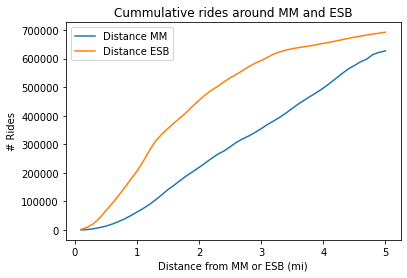

In [62]:
distance_data.plot(kind="line")
plt.title("Cummulative rides around MM and ESB")
plt.ylabel("# Rides")
plt.xlabel("Distance from MM or ESB (mi)")
plt.show()

### Using Geopositional Data with Maps

Wonderful! But I want to represent this data in a way I am most comfortable. If I'm talking geospatial, why not represent everything in reference to an actual map. I love maps.

`folium` is an incredible Python library useful for quick map-based plots. I'm sure there's more robust software out there but this will prove my point for now. The `folium` maps are interactive and I will spend the next couple cells detailing some useful methods.

In [64]:
import folium as folium

In [65]:
lat = uber_data["Lat"].values[:5]
lon = uber_data["Lon"].values[:5]

uber_map = folium.Map(location=[40.7128, -74.0060], zoom_start=12)
#Marker let's you drop markers on the map
#You can also add text to the markers with the popup argument
for i in range(len(lat)):
    folium.Marker((lat[i], lon[i]), popup="Rider {}".format(i+1)).add_to(uber_map)
uber_map

In [66]:
from folium.plugins import HeatMap

lat_lon = uber_data[["Lat", "Lon"]].values[:10000]
uber_map = folium.Map(location=[40.7128, -74.0060], zoom_start=12)
#A heatmap can be plotted like so... the radius argument controls the radius of each point within the map
#You can zoom in on this map to see more specific areas, or out to see more general
HeatMap(lat_lon, radius=13).add_to(uber_map)
uber_map

In [67]:
#We can also give a weight to either give different values to points, or to make the graphs less dense looking
uber_data["Weight"] = .5
lat_lon = uber_data[["Lat", "Lon", "Weight"]].values[:10000]
uber_map = folium.Map(location=[40.7128, -74.0060], zoom_start=12)
#Now let's increase radius since the weights are less
HeatMap(lat_lon, radius=15).add_to(uber_map)
uber_map

In [68]:
#Let's get the points that are within distance of either point of interest
#There won't be overlap if we use only points that are .25 mile away
i = uber_data[["Distance MM", "Distance ESB"]] < .25
i = i.any(axis=1)

map_data = uber_data[i].copy()

map_data["Weight"] = .1
lat_lon = map_data[["Lat", "Lon", "Weight"]].values
uber_map = folium.Map(location=[40.7728, -74.0060], zoom_start=13)
HeatMap(lat_lon, radius=10).add_to(uber_map)
uber_map

### Heat Map timeseries

So far so good. Lastly, I'm taking the first week of data and plotting most of the data for each hour. With `folium` I can make a moving slider to show the UBER ride data evolving with time.

In [69]:
#Let's grab only the date and hour by replacing the other parts with 0
uber_data["Date_Hour"] = uber_data["Date/Time"].apply(lambda x: x.replace(microsecond=0,second=0,minute=0))

from datetime import datetime
#Take only the first week of data
map_data = uber_data[uber_data["Date/Time"] < datetime(2014,7,8)].copy()
map_data["Weight"] = .5
#Randomly sample 1/3 the values in each group
map_data = map_data.groupby('Date_Hour').apply(lambda x: x[["Lat", "Lon", "Weight"]].sample(int(len(x)/3)).values.tolist())
#Get the index
date_hour_index = [x.strftime("%m/%d/%Y, %H:%M:%S") for x in map_data.index]
#Get the data in list form (each element of this bigger list will be a list of lists with lat/lon/weight)
#Each element of the bigger list is a for a date/hour combo
date_hour_data = map_data.tolist()

from folium.plugins import HeatMapWithTime
uber_map = folium.Map(location=[40.7128, -74.0060], zoom_start=12)
#A heatmap with time can now be out together
hm = HeatMapWithTime(date_hour_data, index=date_hour_index)
hm.add_to(uber_map)
uber_map

## Statistics with Hourly Data

Lastly, I'll develop a short module which can do some actual statitstics. I want to know if there's a statistically significatn deviation between the average number of rides per hour on a weekday compared to the weekend.

Getting the hourly average is straightforward:

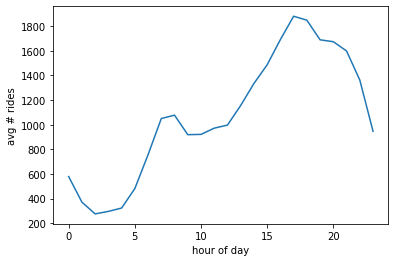

In [71]:
h = hourly_data.groupby(hourly_data.index.hour).mean()
h.plot(kind="line")
plt.ylabel('avg # rides')
plt.xlabel('hour of day')
plt.show()

Separating out the pd data for weekday and weekend is also easy, since I organized things earlier, I just need to mask out the data I dont want with some indexing.

Since we are working with 5 weekdays and 2 weekend (days) I expect the ride average for the weekend to mirror the total average above fairly closely. But weekend data will certainly skew.

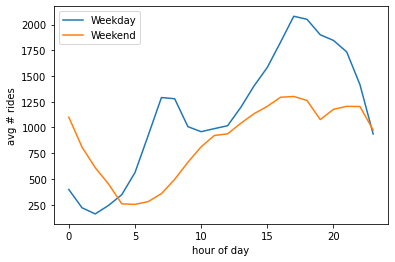

In [73]:
i = hourly_data.index.weekday <= 4

h_week = hourly_data.loc[i].groupby(hourly_data.loc[i].index.hour).mean()
h_weekend = hourly_data.loc[~i].groupby(hourly_data.loc[~i].index.hour).mean()
h = pd.concat([h_week, h_weekend], axis=1)
h.columns = ["Weekday", "Weekend"]

h.plot(kind='line')
plt.ylabel('avg # rides')
plt.xlabel('hour of day')
plt.show()

### Getting p and t values

Normalizing the data is a good idea before doing these kinds of statistics too. Vectorizing a division operation across the whole array such that all data adds to 1 is the easiest way to do this.

I use `scipy`'s ttest to get a quick assesment of the data's behavior. If the t-stats diverge beyond +/-1.96 (if we're being a bit leanient) then a statistically significant divergence has occured between the two data sets.

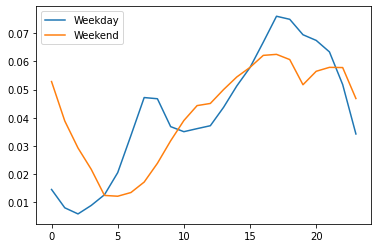

In [76]:
(h / h.sum()).plot(kind='line')
plt.show()

hourly_data_pct = hourly_data.groupby(hourly_data.index.date).apply(lambda x: x / x.sum())

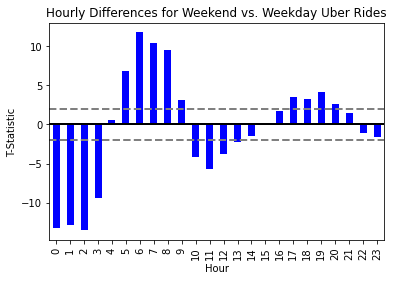

In [77]:
from scipy.stats import ttest_ind

t_stats = hourly_data_pct.groupby(hourly_data_pct.index.hour).apply(lambda x: ttest_ind(x[x.index.weekday<=4], x[x.index.weekday>4])[0])

ax = t_stats.plot(kind='bar', color='blue')
ax.axhline(1.96, linestyle='--', color='grey', linewidth=2)
ax.axhline(0, color='black', linewidth=2)
ax.axhline(-1.96, linestyle='--', color='grey', linewidth=2)
plt.xlabel("Hour")
plt.ylabel("T-Statistic")
plt.title("Hourly Differences for Weekend vs. Weekday Uber Rides")
plt.show()

So, it can clearly be seen that the weekend vs. weekday riders see significant divergences in the early hours (in favor of weekends) and mid-morning for weekdays.

# What's Next?

There's other data that this can be compared to. The NYTA also reports data on Yellow Taxi rides: https://data.cityofnewyork.us/Transportation/2017-Yellow-Taxi-Trip-Data/biws-g3hs

One fun comparison would be to test for significant divergences in normalized average rides between UBER and yellow taxis.

More broadly, consumption data is everywhere, perhaps nowhere moreso than Amazon. I have found some Amazon review data that may be interesting to parse through later: http://jmcauley.ucsd.edu/data/amazon/